In [1]:
import librosa
import pandas as pd
from librosa.effects import pitch_shift
import os
import pathlib
import random
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from librosa.feature import mfcc
import scipy.io.wavfile as wav
import tensorflow as tf
import scipy.signal as signal
import keras
from sklearn.model_selection import train_test_split
from keras.models import Model
from keras.optimizers import adam_v2
from keras.layers import Input, Conv1D, SeparableConv1D, MaxPooling1D, Flatten, Dense, Dropout, \
    BatchNormalization, Activation
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from sklearn.model_selection import train_test_split
from keras.utils.np_utils import to_categorical

# Ensemble Voting Pipeline Development

Use the table of contents to help navigate sections. Note that table of contents do not follow sequential order of code.

* [EVP Tuning](#tuning)
* [Resiliency Testing: Flipped Phones](#flipped)
* [Resiliency Testing: Dropout](#dropout)
* [Performance Plots](#plots)
* [EVP Performance w/o weighting](#no_weights)

In [2]:
#read in truth data for cellphone range from the sUAS and the flight directory of all flights
parent_directory=os.path.abspath(os.path.join(os.getcwd(), ".."))
ranges_df=pd.read_csv("datasets\A3_Range_truth_dot256ms.csv")
truthData=pd.read_csv(parent_directory+"\\flight_directories\\A3_flight_directory.csv")
mean_std=pd.read_csv("datasets\mean_std_training_ds_wo_A1_matrice_phantom.csv")
mean=np.array(mean_std.loc[:,'mean'])
std=np.array(mean_std.loc[:,'std'])

In [3]:
from sklearn.metrics import accuracy_score, balanced_accuracy_score, recall_score, precision_score,f1_score
import pickle
from sklearn.metrics import accuracy_score, balanced_accuracy_score, recall_score, precision_score
import datetime
phone_slots=["Phone_1-1","Phone_1-3","Phone_11","Phone_12","Phone_15","Phone_2-3","Phone_2-4", "Phone_2-5","Phone_27","Phone_28","Phone_29", "Phone_3-1","Phone_3-2","Phone_3-3","Phone_3-4","Phone_3-5","Phone_30","Phone_5-2","Phone_5-3","Phone_5-4","Phone_6-2","Phone_6-3","Phone_6-4","Phone_6-5","Phone_7-1","Phone_7-2","Phone_8","Phone_9"]
notable_col_names=['Pass','Segment','Phone','Lat','Lon','Alt','Range']
droneDict = {  # One hot encoding for labels probs should do it like I did below?
    "Drone": [1, 0],
    "Noise": [0, 1]
}
bad_runs=["A3R3P1","A3R6P1","A3R4P4","A3R4P5","A3R3P4","A3R3P5"] #aka used for training
tuning_runs=["A3R5P3","A3R4P2","A3R6P3"]


Read in all necessary functions

In [4]:
NOISE=0
DRONE=1
def findClosestPhone(phoneRanges): #phoneList is a list of all N phone ranges
    """This function returns the closest cellphone's prediction and associated truth value.
    (not really used for evaluation, can be ignored)
    :param phoneList: A list of all N phone ranges
    :returns best_prediction: the prediction of the closest cellphone
    :returns truth_val: associated truth value"""
    closest_range=10000
    best_prediction=0
    for x in phoneRanges:
        phone_dist=x[0]
        if phone_dist<closest_range:
            best_prediction=x[1]
            closest_range=phone_dist

    if closest_range <=80:
        truth_val=1
    else:
        truth_val=0
    return int(best_prediction), truth_val

def weighting(maxVals):
    """This function returns the softmax normalization of all cellphone's zeroth MFCC values.
    :param maxVals: An array of all cellphone's zeroth MFCC for a given 256ms frame
    :returns weights: Weighting of all sensors (between 0.0-1.0 and sums to 1.0)"""
    maxVals_copy=maxVals
    layer = tf.keras.layers.Softmax(axis=-1)
    weights=layer(maxVals_copy)
    return weights


json_file=open(r"models\ANN_LT80_wo_A1_A3_added.json", 'r')
loaded_network_json = json_file.read()
json_file.close()
loaded_network = tf.keras.models.model_from_json(loaded_network_json)
#loaded_network.load_weights(r"C:\Users\rclendening\PycharmProjects\MLTesting\research\research\MLModels\models\1DCNN_PL_V3(final)").expect_partial()
loaded_network.load_weights(r"models\ANN_LT80_wo_A1_A3_added").expect_partial()

loaded_network.compile(optimizer='nadam',
    loss=tf.keras.losses.BinaryCrossentropy(from_logits=False),
    metrics=['accuracy'],)
# loaded_network = keras.models.load_model('test_01_31')

filename = 'models/finalized_svm_model.sav'
loaded_model = pickle.load(open(filename, 'rb'))
def MFCCCalc(audioData, Fs):
    """
    Converts decoded wav file to MFCC feature space
    @param: audioData: Numpy array of decoded audio wav file
    @param: Fs: Sampling rate (8KHz)
    @return: MFCC 40 coefficients
    """
    #audioData=audioData.numpy()
    data= audioData.astype(float)
    #coefs = mfcc(data, sr=sampleRate, hop_length=2048)
    coefs = mfcc(y=data, hop_length=2048,n_fft=2048,n_mfcc=40, sr=Fs)
    return coefs

def split_test_audio(waveData, labelName, sampleFreq):
    """
    Frames audio data and converts to feature space (spectrogram)
    :param waveData: waveData array of time-domain audio
    :param frame_duration: Duration of frames desired
    :param startTime: Start for each clip
    :param sampleFreq: Sample Frequency (8Khz)
    :param labelName: Name of label
    @return list of features (ds), list of labels corresponding to feature dataset:
    """
    duration = waveData.shape[0]
    features=MFCCCalc(waveData.squeeze(),Fs=8000)
    label= [droneDict[labelName]] * features.shape[1]
    return features, label
def create_test_dataset(test_files, testTime,testName):
    """
    Creates feature dataset and label dataset.
    @param test_files: EagerTensor of file paths.
    @return list of features (ds), list of labels corresponding to feature dataset:
    """
    featuresLL=[]
    numPhones=0
    pass_df=ranges_df.loc[ranges_df[str(notable_col_names.index('Pass'))] == testName]
    for x in test_files:
        phoneName = x.split('\\')[7][:-4]
        test_audio, sampleRate = librosa.load(x, sr=8000)
        if len(test_audio) == (testTime)*sampleRate and min(np.asarray(test_audio)) != 0: #ensure data actually has sound and recorded correctly
    #if x.split('\\')[7] in usable_phones:
            numPhones+=1
            x = str(x)
            #print(x.split('\\')[7])
            phoneName = x.split('\\')[7][:-4]
            #label = label[6]
            #test_audio = test_audio[0: (testTime-1)*sampleRate]  # trim to nearest second removed for consistency sake
            newFeats=MFCCCalc(test_audio.squeeze(),Fs=8000)
            phone_seg=pass_df.loc[pass_df[str(notable_col_names.index('Phone'))]==phoneName]
            if len(np.array(phone_seg.iloc[:,7]))>0:
                featuresLL.append([phoneName,newFeats.transpose(),np.array(phone_seg.iloc[:,7])])
    return featuresLL

def maxValues(features):
    """Returns each cellphone's zeroth MFCC value in a list
    :param features: list of all cellphone's MFCC values
    :returns maxVals: A list of all zeroth MFCC values"""
    maxVals=[]
    for x in features:
        #maxVals.append(abs(x).max())
        #print("val:",(x[0][0]))
        maxVals.append(x[0]) #average power of signal
    return maxVals

# FSMs, very basic, predict sUAS if val>number
def zeroBitPrediction(prevPredictState,prediction): #prediction need to be 1 (noise) or -1 (drone)
    if prediction == NOISE:
        predVal=0
    else:
        predVal=1
    return prevPredictState, predVal

def twoBitPrediction(prevPredictState,prediction): #prediction need to be 1 (noise) or -1 (drone)
    if prediction == NOISE:
        predVal=-1
    else:
        predVal=1
    if prevPredictState+predVal>1:
        actualPrediction= 1
    else:
        actualPrediction = 0
    prevPredictState=prevPredictState+predVal
    if prevPredictState>3:
        prevPredictState=3
    elif prevPredictState<0:
        prevPredictState=0
    return prevPredictState, actualPrediction

def threeBitPrediction(prevPredictState,prediction): #prediction need to be 1 (noise) or -1 (drone)
    if prediction == NOISE:
        predVal=-1
    else:
        predVal=1
    if prevPredictState+predVal>3:
        actualPrediction= 1
    else:
        actualPrediction = 0
    prevPredictState=prevPredictState+predVal
    if prevPredictState>7:
        prevPredictState=7
    elif prevPredictState<0:
        prevPredictState=0
    return prevPredictState, actualPrediction

def fourBitPrediction(prevPredictState,prediction): #prediction need to be 1 (noise) or -1 (drone)
    if prediction == NOISE:
        predVal=-1
    else:
        predVal=1
    if prevPredictState+predVal>15:
        actualPrediction= 1
    else:
        actualPrediction = 0
    prevPredictState=prevPredictState+predVal
    if prevPredictState>31:
        prevPredictState=31
    elif prevPredictState<0:
        prevPredictState=0
    return prevPredictState, actualPrediction

In [7]:
loaded_model

KeyboardInterrupt: 

# EVP Tuning <a class="anchor" id="tuning"></a>

In [20]:

start=0
novelAve=[]
sumAve=[]
outPerform=[]
recall=[]
precision=[]

def majorityVoteTuning(testFeats, fusionThresh,networkThresh, FSMVal):
    """Tunes the core of the EVP by determining the best fusion threshold, NN confidence threshold, and FSM values.
    :param Testfeats: List of all usable devices' MFCC values
     :param fusionThresh: Value for voting threshold
     :param networkThresh: Value for NN confidence threshold
     :param FSMVal: FSM selection
     :returns predictedList: List of EVP predictions for the test flight
     :returns y_prediction: 2D list of all cellphones' predictions
     :returns truth_valueList: EVP truth value"""
    y_prediction=[]
    maxVals=[]
    for x in testFeats:
        features_list=x[1]
        features_list -= mean
        features_list /= std
        #features_list= np.reshape(features_list, (len(features_list), 40, 1))
        maxVals.append(maxValues(features_list))
        pred=loaded_network.predict(features_list)[:] > networkThresh
        # pred.astype(int)
        #pred = model.predict(x.squeeze()) #for SVM
        #pred=naivePred(features_list,networkThresh)
        y_prediction.append(pred)

    maxVals=np.asarray(maxVals).transpose()
    vote_weights=weighting(maxVals)
    numPhones=len(y_prediction)
    predictedList=[]
    truth_valueList=[]
    prevState=FSMVal**2/2
    for i in range(len(testFeats[0][2])): # i is feature frame
        predictedDrone=0
        phone_ranges=[]
        for j in range(len(y_prediction)): # j is phone
            if y_prediction[j][i] == 1:
                #predictedDrone+= 1*maxValueRankArr[i][j]
                predictedDrone+= 1*float(vote_weights[i][j])
            if len(testFeats[j][2]>0):
                phone_ranges.append([testFeats[j][2][i],y_prediction[j][i]]) #this is the range at the current frame
            else:
                phone_ranges.append([100000,y_prediction[j][i]])
        if predictedDrone >fusionThresh: #adjusted from 0.6 to 0.7
        #if predictedDrone/numPhones >0.63:
        #if predictedDrone/5 >0.50:
            predictedVal=1
            #predictedList.append(0)
        else:
            #predictedList.append(1)
            predictedVal=0
        if FSMVal ==0:
            prevState, prediction=zeroBitPrediction(prevState, predictedVal)
        if FSMVal ==1:
            prevState, prediction=twoBitPrediction(prevState, predictedVal)
        if FSMVal ==2:
            prevState, prediction=threeBitPrediction(prevState, predictedVal)
        if FSMVal ==3:
            prevState, prediction=fourBitPrediction(prevState, predictedVal)
        predictedList.append(prediction)
        best_indiv_predict,truth_value=findClosestPhone(phone_ranges)
        truth_valueList.append(truth_value)

    return predictedList, y_prediction,truth_valueList

def tuning(fusion_thresholds,net_thresholds,FSMS):
    """Iterates over different threshold values
    :param fusion_thresholds: voting threshold
    :param net_thresholds: ANN threshold
    :param FSMS: Type of FSM selected
    :returns None"""
    best_fusion=0.0
    best_network=0.0
    best_score=0.0
    best_FSM=0
    for fus_thresh in fusion_thresholds:
        for fsm in FSMS:
            for net_thresh in net_thresholds:
                novelAve=[]
                print(fus_thresh,net_thresh,fsm)
                for x in range(18):
                    indiv_scores=[]
                    truthScenario = truthData.iloc[x]
                    pass_num=truthScenario[0]
                    scenario=truthScenario[1]
                    run_num=truthScenario[2]
                    start=truthScenario[3]
                    stop=truthScenario[4]
                    start_time=datetime.datetime(2021, 8, int(start[6:8]), int(start[9:11]), int(start[11:13]),int(start[13:15])).timestamp()
                    stop_time=datetime.datetime(2021, 8, int(stop[6:8]), int(stop[9:11]), int(stop[11:13]),int(stop[13:15])).timestamp()
                    testTime= int(stop_time-start_time)
                    full_name=(str(scenario) + 'R' + str(run_num) + 'P' + str(pass_num)).strip()
                    if full_name in tuning_runs:
                        #read scenario and truth data
                        name=truthScenario[0]
                        startDetect= truthScenario[1]
                        endDetect=truthScenario[2]
                        dataset_path: str = "C:\\Users\\rclendening\\researchData\\EscapeCell_DataWav_v2\\A3\\"+full_name
                        Testdata_dir = pathlib.Path(dataset_path)
                        phones = tf.io.gfile.glob(str(Testdata_dir) + '/*')
                        # convert to MFCC space
                        featuresLL =create_test_dataset(phones, testTime, testName=full_name)
                        predictedList, y_prediction,truth_valueList= majorityVoteTuning(featuresLL,fus_thresh,net_thresh,fsm)
                        #
                        for z in range(len(featuresLL)): #iterate over cellphones
                                    if len(featuresLL[z][2]>0):
                                        val=featuresLL[z][2]<80
                                        indiv_scores.append(f1_score(y_true=val,y_pred=y_prediction[z][0:len(val)]))
                        # Report balanced accuracy scores
                        #################### Score Reporting #################
                        #best_phone_score=np.average(indiv_scores)
                        fusion_score=f1_score(y_true=truth_valueList,y_pred=predictedList)
                        novelAve.append(fusion_score)
                        #novelAve.append(best_phone_score)
                        print(np.average(novelAve))
                if np.average(novelAve) > best_score:
                    best_fusion=fus_thresh
                    best_network=net_thresh
                    best_score=np.average(novelAve)
                    best_FSM=fsm
    print("Best fusion threshold:",best_fusion)
    print("Best network threshold:",best_network)
    print("Best network threshold:",best_FSM)
FSM_vals=[2]
fusion_vals=[0.16,0.18,0.2,0.22,0.24,0.26]
thresh_vals=[0.84,0.86,0.88,0.90,0.92,0.94]
#thresh_vals=[0.5,0.55,0.6,0.65,0.7,0.4]
tuning(fusion_vals,thresh_vals,FSM_vals)

0.16 0.84 2
13/13 [==============================] - 0s 2ms/step
0.7578947368421053
14/14 [==============================] - 0s 1ms/step
0.7758939333065489
12/12 [==============================] - 0s 926us/step
0.8157700848909331
0.16 0.86 2
13/13 [==============================] - 0s 1ms/step
0.7578947368421053
14/14 [==============================] - 0s 592us/step
0.7758939333065489
12/12 [==============================] - 0s 926us/step
0.8104563394818528
0.16 0.88 2
13/13 [==============================] - 0s 947us/step
0.7513227513227514
14/14 [==============================] - 0s 2ms/step
0.7741288086115672
12/12 [==============================] - 0s 835us/step
0.8012908634950554
0.16 0.9 2
13/13 [==============================] - 0s 839us/step
0.7553191489361701
14/14 [==============================] - 0s 929us/step
0.7714819682904789
12/12 [==============================] - 0s 728us/step
0.8010596634481328
0.16 0.92 2
13/13 [==============================] - 0s 843us/step
0.7553

# Performance evaluation

In [6]:
import time
indiv_phone_f1_dict={}
indiv_phone_recall_dict={}
indiv_phone_prec_dict={}
for x in phone_slots:
    indiv_phone_f1_dict[x]=[]
    indiv_phone_prec_dict[x]=[]
    indiv_phone_recall_dict[x]=[]
start=0
novelAve=[]
sumAve=[]
outPerform=[]
recall=[]
precision=[]
recall_stddev=[]
score_stddev=[]
phone_count=[]
indiv_precisions=[]
indiv_recalls=[]
indiv_accuracies=[]
indiv_scores=[]
total_pred=[]
total_truth=[]
total_ranges=[]
time_per_prediction=[]
evp_f1=[]
detectable_count=[]
tot_test_time=0
test_truth_evp=[]
test_truth_indiv=[]
#re-defined but same function as before

def naivePred(testFeats,thresh):
    predList=[]
    for x in testFeats:
        if x[0]>thresh:
            predList.append(1)
        else:
            predList.append(0)
    return predList

def majorityVoteTuning(testFeats, fusionThresh,networkThresh, FSMVal):
    """Tunes the core of the EVP by determining the best fusion threshold, NN confidence threshold, and FSM values.
    :param Testfeats: List of all usable devices' MFCC values
     :param fusionThresh: Value for voting threshold
     :param networkThresh: Value for NN confidence threshold
     :param FSMVal: FSM selection
     :returns predictedList: List of EVP predictions for the test flight
     :returns y_prediction: 2D list of all cellphones' predictions
     :returns truth_valueList: EVP truth value"""
    y_prediction=[]
    maxVals=[]
    for x in testFeats:
        features_list=x[1]
        features_list -= mean
        features_list /= std
        if len(x[2]) > 0:
            #features_list= np.reshape(features_list, (len(features_list), 40, 1))
            maxVals.append(maxValues(features_list))
            start_time=time.perf_counter()
            pred=loaded_network.predict(features_list)[:] > networkThresh
            #pred=naivePred(features_list,networkThresh)
            #pred=loaded_model.predict(features_list)[:]
            end_time=time.perf_counter()
            time_per_prediction.append((end_time-start_time)/len(pred))
            #pred.astype(int)
            #pred = model.predict(x.squeeze()) #for SVM
            y_prediction.append(pred)

    maxVals=np.asarray(maxVals).transpose()
    vote_weights=weighting(maxVals)
    numPhones=len(y_prediction)
    predictedList=[]
    truth_valueList=[]
    prevState=FSMVal**2/2
    for i in range(len(testFeats[0][2])): # i is feature frame
        predictedDrone=0
        phone_ranges=[]
        for j in range(len(y_prediction)): # j is phone
            if y_prediction[j][i] == 1:
                #predictedDrone+= 1*maxValueRankArr[i][j]
                predictedDrone+= 1*float(vote_weights[i][j])
            if len(testFeats[j][2]>0):
                phone_ranges.append([testFeats[j][2][i],y_prediction[j][i]]) #this is the range at the current frame
            else:
                phone_ranges.append([100000,y_prediction[j][i]])
        if predictedDrone >fusionThresh: #adjusted from 0.6 to 0.7
        #if predictedDrone/numPhones >0.63:
        #if predictedDrone/5 >0.50:
            predictedVal=1
            #predictedList.append(0)
        else:
            #predictedList.append(1)
            predictedVal=0
        if FSMVal ==0:
            prevState, prediction=zeroBitPrediction(prevState, predictedVal)
        if FSMVal ==1:
            prevState, prediction=twoBitPrediction(prevState, predictedVal)
        if FSMVal ==2:
            prevState, prediction=threeBitPrediction(prevState, predictedVal)
        if FSMVal ==3:
            prevState, prediction=fourBitPrediction(prevState, predictedVal)
        predictedList.append(prediction)
        best_indiv_predict,truth_value=findClosestPhone(phone_ranges)
        truth_valueList.append(truth_value)

    return predictedList, y_prediction,truth_valueList

for x in range(18):
    #read scenario and truth data
    truthScenario = truthData.iloc[x]
    pass_num=truthScenario[0]
    scenario=truthScenario[1]
    run_num=truthScenario[2]
    start=truthScenario[3]
    stop=truthScenario[4]
    drone_gps_file=truthScenario[5]
    start_time=datetime.datetime(2021, 8, int(start[6:8]), int(start[9:11]), int(start[11:13]),int(start[13:15])).timestamp()
    stop_time=datetime.datetime(2021, 8, int(stop[6:8]), int(stop[9:11]), int(stop[11:13]),int(stop[13:15])).timestamp()
    testTime= int(stop_time-start_time)
    full_name=(str(scenario) + 'R' + str(run_num) + 'P' + str(pass_num)).strip()
    print(full_name)
    if full_name not in tuning_runs and full_name not in bad_runs:
        dataset_path: str = "C:\\Users\\rclendening\\researchData\\EscapeCell_DataWav_V2\\A3\\"+full_name
        Testdata_dir = pathlib.Path(dataset_path)
        phones = tf.io.gfile.glob(str(Testdata_dir) + '/*')
        tot_test_time+=testTime
        # convert to MFCC space
        featuresLL =create_test_dataset(phones, testTime, testName=full_name)
        predictedList, y_prediction,truth_valueList= majorityVoteTuning(featuresLL,fusionThresh=0.2,networkThresh=0.9,FSMVal=2)
        # if full_name== "A3R6P2":
        #     names=pd.DataFrame()
        #     i=0
        #     for x in featuresLL:
        #         names[x[0]]=y_prediction[i].squeeze()
        #         i+=1
        #     # R6P2_truth=pd.DataFrame(predictedList)
        #     # R6P2_truth.to_csv("R6P2_truth.csv")
        #     names.to_csv("R6P2_truth_v2.csv")
        num_frames=len(predictedList) #length of one scenario in frames
        # Report balanced accuracy scores
        tot_indiv_score=0
        tot_recall_score=0
        tot_precision_score=0
        tot_detectable=np.zeros(num_frames)
        for z in range(len(y_prediction)): #iterate over cellphones
            if len(featuresLL[z][2]>0):
                for range_val in range(len(featuresLL[z][2])):
                    if featuresLL[z][2][int(range_val)]<80:
                        total_ranges.append(featuresLL[z][2][int(range_val)])
                val=featuresLL[z][2]<80
                tot_detectable+=val
                phone_name= featuresLL[z][0]
                if phone_name== "Phone_3-2":
                    print("USED HERE")
                    print(f1_score(y_true=val,y_pred=y_prediction[z][0:len(val)]))
                    print("--------------")
                total_truth.extend(val)
                total_pred.extend(y_prediction[z][0:len(val)])
                indiv_phone_f1_dict[phone_name].append(f1_score(y_true=val,y_pred=y_prediction[z][0:len(val)]))
                indiv_phone_recall_dict[phone_name].append(recall_score(y_true=val,y_pred=y_prediction[z][0:len(val)]))
                indiv_phone_prec_dict[phone_name].append(precision_score(y_true=val,y_pred=y_prediction[z][0:len(val)]))
                indiv_accuracies.append(accuracy_score(y_true=val,y_pred=y_prediction[z][0:len(val)]))
                indiv_recalls.append(recall_score(val,y_prediction[z][0:len(val)]))
                indiv_precisions.append(precision_score(val,y_prediction[z][0:len(val)]))
                indiv_scores.append(f1_score(y_true=val,y_pred=y_prediction[z][0:len(val)]))
        test_truth_evp.extend(truth_valueList)
        test_truth_indiv.extend(featuresLL[0][2]<80)
        #################### Score Reporting #################
        detectable_count.extend(tot_detectable[np.where(tot_detectable!=0)])
        indiv_score_ave=np.average(indiv_scores)
        print(full_name)
        print("Number of used phones:",len(y_prediction))
        fusion_score=accuracy_score(y_true=truth_valueList,y_pred=predictedList)
        fusion_f1_score=f1_score(y_true=truth_valueList,y_pred=predictedList)
        novelAve.append(fusion_score)
        phone_count.append([len(y_prediction),fusion_f1_score])
        print("Average Recall value:", recall_score(truth_valueList,predictedList))
        print("Average Precision value:", precision_score(truth_valueList,predictedList))
        print("Accuracy for drone present:", fusion_score)
        print("Indiv Accuracy for drone present:", indiv_score_ave)
        performanceGain=100*((fusion_f1_score-indiv_score_ave)/indiv_score_ave)
        evp_f1.append(fusion_f1_score)
        outPerform.append(performanceGain)
        recall.append(recall_score(truth_valueList,predictedList))
        precision.append(precision_score(truth_valueList,predictedList))
        # print("Recall score:", recall_score(truth_valueList,predictedList))
        # print("Precision score:", precision_score(truth_valueList,predictedList))
        # print("Novel method outperforms by:", performanceGain, "%")
        print("_________________________")
        if full_name == "A3R4P1":
            print()
        # for x in range(len(featuresLL)):
        #     if len(featuresLL[x][2]>0):
        #         plt.title(featuresLL[x][0])
        #         plt.plot(featuresLL[x][2],y_prediction[x][0:len(featuresLL[x][2])])
        #         #plt.plot(range(0,len(y_prediction[0])),y_prediction[x])
        #         plt.figure()
        # plt.plot(range(0,len(truth_valueList)),truth_valueList)
        # plt.plot(range(0,len(predictedList)),predictedList)

print("Indiv Recall", np.average(indiv_recalls))
print("Indiv Precision", np.average(indiv_precisions))
print("Indiv F1", np.average(indiv_scores))
print("EVP Recall",np.average(recall))
print(" EVP Precision",np.average(precision))
print("EVP Accuracy",np.average(novelAve))
print("EVP F1",np.average(evp_f1))
print("Indiv Accuracy", np.average(indiv_accuracies))
print("Outperform",np.average(outPerform))

A3R3P1
A3R3P2


KeyboardInterrupt: 

# Performance Plots <a class="anchor" id="plots"></a>

([<matplotlib.axis.YTick at 0x274fa3bdf10>,
 [Text(0, 0.0, '0'), Text(0, 1.0, '1'), Text(0, 2.0, '2'), Text(0, 3.0, '3')])

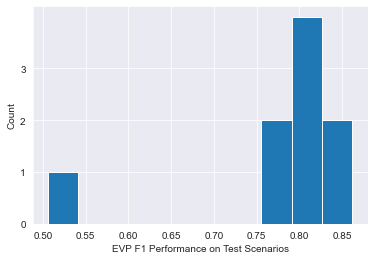

In [26]:
#plt.hist(indiv_scores)
plt.hist(evp_f1)
plt.ylabel("Count")
plt.xlabel("EVP F1 Performance on Test Scenarios")
plt.yticks(np.arange(0, 4, 1.0))
#plt.savefig("./Plots/evp_f1_performance.pdf",bbox_inches="tight")

914


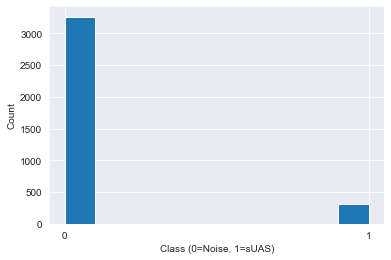

In [22]:
print(tot_test_time)
#plt.hist(test_truth_evp)
plt.hist(np.array(test_truth_indiv,int))
plt.ylabel("Count")
plt.xticks(np.arange(0, 1.000001, 1.0))
plt.xlabel("Class (0=Noise, 1=sUAS)")
plt.savefig("./Plots/indiv_test_distro_hist.pdf",bbox_inches="tight")

#plt.hist(np.array(test_truth_indiv,int))

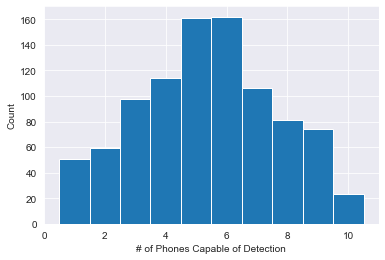

In [114]:
plt.xlabel("# of Phones Capable of Detection")
plt.ylabel("Count")
plt.hist(np.array(detectable_count),bins=range(1,12),align="left",rwidth=1)
plt.savefig("./Plots/number_of_detectable_phones.pdf",bbox_inches="tight")

In [49]:
np.average(time_per_prediction)

0.00012533999900021776

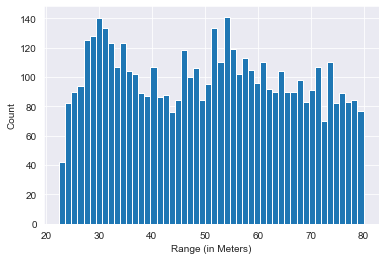

In [90]:
plt.hist(total_ranges,bins=50)
plt.ylabel("Count")
plt.xlabel("Range (in Meters)")
plt.savefig("./Plots/cellphone_test_ranges_hist_LT80.pdf",bbox_inches="tight")


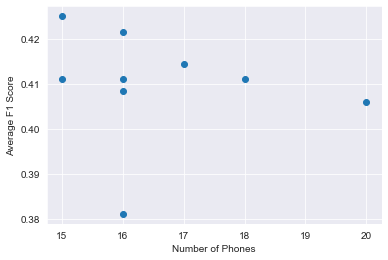

In [8]:
phone_count=np.array(phone_count)
plt.ylabel("Average F1 Score")
plt.xlabel("Number of Phones")
#plt.title("F1 Scores vs Phone Dropout")
plt.scatter(phone_count[:,0],phone_count[:,1])
plt.savefig("./Plots/Cellphone_resiliency_with_celldropout_svm.pdf",bbox_inches="tight")

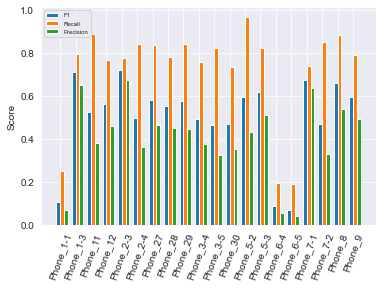

In [215]:
f1_average_values=[]
recall_average_values=[]
prec_average_values=[]
names=[]
ind=np.arange(20)
width=0.25
for x in indiv_phone_f1_dict:
    if len(indiv_phone_f1_dict[x])>0:
        names.append(x)
        f1_average_values.append(np.average(indiv_phone_f1_dict[x]))
        recall_average_values.append(np.average(indiv_phone_recall_dict[x]))
        prec_average_values.append(np.average(indiv_phone_prec_dict[x]))
bar1=plt.bar(ind,np.array(f1_average_values),align='edge',width=width)
bar2=plt.bar(ind+width,np.array(recall_average_values),align='edge',width=width)
bar3=plt.bar(ind+2*width,np.array(prec_average_values),align='edge',width=width)
plt.legend( (bar1, bar2, bar3), ('F1', 'Recall', 'Precision'),loc="upper left", prop={'size':6})
plt.xticks(ind+width,names)

plt.xticks(rotation=70)
plt.ylabel("Score")
#plt.savefig("./Plots/F1_Score_Devices_SVM.pdf",bbox_inches="tight")

# Resiliency Experiments (Flipped Phones) <a class="anchor" id="flipped"></a>

In [7]:
drop_phone_case=[0,1,2,3,4,5,6,10]
import random
def randomNumbers(n,max):
    """Generate random numbers and return them in a list.
    :param n: Number of random integers to generate
    :param max: Max integer to generate
    :returns list of n random integers"""
    values=[]
    for x in range(0,n):
        new=False
        while new!=True:
            val=random.randint(0,max)
            if not (val in values):
                values.append(val)
                new =True
    return values


def majorityVoteResiliency(testFeats, fusionThresh,networkThresh, FSMVal,numFlipped):
    """Modified majority vote function for evaluating flipped phones.
     :param Testfeats: List of all usable devices' MFCC values
     :param fusionThresh: Value for voting threshold
     :param networkThresh: Value for NN confidence threshold
     :param FSMVal: FSM selection
     :returns predictedList: List of EVP predictions for the test flight
     :returns y_prediction: 2D list of all cellphones' predictions
     :returns truth_valueList: EVP truth value"""
    y_prediction=[]
    maxVals=[]
    for x in testFeats:
        features_list=x[1]
        features_list -= mean
        features_list /= std
        #features_list= np.reshape(features_list, (len(features_list), 40, 1))
        maxVals.append(maxValues(features_list))
        pred=loaded_network.predict(features_list)[:] > networkThresh
        pred.astype(int)
        #pred = model.predict(x.squeeze()) #for SVM
        y_prediction.append(pred)

    maxVals=np.asarray(maxVals).transpose()
    vote_weights=weighting(maxVals)
    numPhones=len(y_prediction)
    predictedList=[]
    truth_valueList=[]
    random_values=randomNumbers(14,(len(y_prediction)-1))
    for i in range(numFlipped):
        y_prediction[random_values[i]]=~y_prediction[random_values[i]]
    prevState=FSMVal**2/2
    for i in range(len(testFeats[0][2])): # i is feature frame
        predictedDrone=0
        phone_ranges=[]
        for j in range(len(y_prediction)): # j is phone
            if y_prediction[j][i] == 1:
                predictedDrone+= 1*float(vote_weights[i][j])
            if len(testFeats[j][2]>0):
                phone_ranges.append([testFeats[j][2][i],y_prediction[j][i]]) #this is the range at the current frame
            else:
                phone_ranges.append([100000,y_prediction[j][i]])
        if predictedDrone >fusionThresh:
            predictedVal=1
        else:
            predictedVal=0
        if FSMVal ==0:
            prevState, prediction=zeroBitPrediction(prevState, predictedVal)
        if FSMVal ==1:
            prevState, prediction=twoBitPrediction(prevState, predictedVal)
        if FSMVal ==2:
            prevState, prediction=threeBitPrediction(prevState, predictedVal)
        if FSMVal ==3:
            prevState, prediction=fourBitPrediction(prevState, predictedVal)
        predictedList.append(prediction)
        best_indiv_predict,truth_value=findClosestPhone(phone_ranges)
        truth_valueList.append(truth_value)

    return predictedList, y_prediction,truth_valueList
total_evp_f1=[]
total_indiv_f1=[]
for cases in drop_phone_case:
    res_indiv_recall=[]
    res_indiv_prec=[]
    res_indiv_f1=[]
    res_indiv_acc=[]
    res_evp_recall=[]
    res_evp_prec=[]
    res_evp_f1=[]
    res_evp_acc=[]
    for x in range(4):
        novelAve=[]
        sumAve=[]
        outPerform=[]
        recall=[]
        precision=[]
        recall_stddev=[]
        score_stddev=[]
        phone_count=[]
        indiv_precisions=[]
        indiv_recalls=[]
        indiv_accuracies=[]
        indiv_scores=[]
        total_pred=[]
        total_truth=[]
        total_ranges=[]
        time_per_prediction=[]
        evp_f1=[]
        for x in range(18):
            #read scenario and truth data
            truthScenario = truthData.iloc[x]
            pass_num=truthScenario[0]
            scenario=truthScenario[1]
            run_num=truthScenario[2]
            start=truthScenario[3]
            stop=truthScenario[4]
            drone_gps_file=truthScenario[5]
            start_time=datetime.datetime(2021, 8, int(start[6:8]), int(start[9:11]), int(start[11:13]),int(start[13:15])).timestamp()
            stop_time=datetime.datetime(2021, 8, int(stop[6:8]), int(stop[9:11]), int(stop[11:13]),int(stop[13:15])).timestamp()
            testTime= int(stop_time-start_time)
            full_name=(str(scenario) + 'R' + str(run_num) + 'P' + str(pass_num)).strip()
            print(full_name)
            if full_name not in tuning_runs and full_name not in bad_runs:
                dataset_path: str = "C:\\Users\\rclendening\\researchData\\EscapeCell_DataWav_V2\\A3\\"+full_name
                Testdata_dir = pathlib.Path(dataset_path)
                phones = tf.io.gfile.glob(str(Testdata_dir) + '/*')
                # convert to MFCC space
                featuresLL =create_test_dataset(phones, testTime, testName=full_name)
                predictedList, y_prediction,truth_valueList= majorityVoteResiliency(featuresLL,fusionThresh=0.2,networkThresh=0.90,FSMVal=2,numFlipped=cases)
                # Make predictions using network, predictedList is the pipeline's predictions, whereas y_prediction is just cellphone's
                #fusion_prediction, y_prediction = majorityVoteNew(featuresLL)
                #
                num_frames=len(predictedList) #length of one scenario in frames
                # Report balanced accuracy scores
                tot_indiv_score=0
                tot_recall_score=0
                tot_precision_score=0
                for z in range(len(featuresLL)):
                    if len(featuresLL[z][2]>0):
                        for range_val in range(len(featuresLL[z][2])):
                            if featuresLL[z][2][int(range_val)]<80:
                                total_ranges.append(featuresLL[z][2][int(range_val)])
                        val=featuresLL[z][2]<80
                        phone_name=featuresLL[z][0]
                        total_truth.extend(val)
                        total_pred.extend(y_prediction[z][0:len(val)])
                        indiv_phone_f1_dict[phone_name].append(f1_score(y_true=val,y_pred=y_prediction[z][0:len(val)]))
                        indiv_phone_recall_dict[phone_name].append(recall_score(y_true=val,y_pred=y_prediction[z][0:len(val)]))
                        indiv_phone_prec_dict[phone_name].append(precision_score(y_true=val,y_pred=y_prediction[z][0:len(val)]))
                        indiv_accuracies.append(accuracy_score(y_true=val,y_pred=y_prediction[z][0:len(val)]))
                        indiv_recalls.append(recall_score(val,y_prediction[z][0:len(val)]))
                        indiv_precisions.append(precision_score(val,y_prediction[z][0:len(val)]))
                        indiv_scores.append(f1_score(y_true=val,y_pred=y_prediction[z][0:len(val)]))
                #################### Score Reporting #################
                indiv_score_ave=np.average(indiv_scores)
                print(full_name)
                print("Number of used phones:",len(y_prediction))
                fusion_score=accuracy_score(y_true=truth_valueList,y_pred=predictedList)
                fusion_f1_score=f1_score(y_true=truth_valueList,y_pred=predictedList)
                novelAve.append(fusion_score)
                phone_count.append([len(y_prediction),fusion_f1_score])
                performanceGain=100*((fusion_f1_score-indiv_score_ave)/indiv_score_ave)
                evp_f1.append(fusion_f1_score)
                outPerform.append(performanceGain)
                recall.append(recall_score(truth_valueList,predictedList))
                precision.append(precision_score(truth_valueList,predictedList))

        res_indiv_recall.append(np.average(indiv_recalls))
        res_indiv_prec.append(np.average(indiv_precisions))
        res_indiv_f1.append(np.average(indiv_scores))
        res_indiv_acc.append(np.average(indiv_accuracies))
        res_evp_recall.append(np.average(recall))
        res_evp_prec.append(np.average(precision))
        res_evp_acc.append(np.average(novelAve))
        res_evp_f1.append(np.average(evp_f1))

    total_evp_f1.append(np.average(res_evp_f1))
    total_indiv_f1.append(np.average(res_indiv_f1))

A3R3P1
A3R3P2
12/12 [==============================] - 0s 2ms/step
A3R3P2
Number of used phones: 16
A3R3P3
12/12 [==============================] - 0s 1ms/step
A3R3P3
Number of used phones: 17
A3R3P4
A3R3P5
A3R4P1
12/12 [==============================] - 0s 1ms/step
A3R4P1
Number of used phones: 20
A3R4P2
A3R4P3
12/12 [==============================] - 0s 1ms/step
A3R4P3
Number of used phones: 18
A3R4P4
A3R4P5
A3R5P1
14/14 [==============================] - 0s 1ms/step
A3R5P1
Number of used phones: 16
A3R5P2
14/14 [==============================] - 0s 1000us/step
A3R5P2
Number of used phones: 15
A3R5P3
A3R5P4
14/14 [==============================] - 0s 1ms/step
A3R5P4
Number of used phones: 15
A3R6P1
A3R6P2
12/12 [==============================] - 0s 1ms/step
A3R6P2
Number of used phones: 16
A3R6P3
A3R6P4
12/12 [==============================] - 0s 999us/step
A3R6P4
Number of used phones: 16
A3R3P1
A3R3P2
12/12 [==============================] - 0s 1ms/step
A3R3P2
Number of used phones

In [111]:
print("EVP Performance:",np.average(res_evp_f1))
print("______________")
print("Individual Performance:",np.average(res_indiv_f1))

0.26045865418172004
0.992508730683382
0.2590581497078239
0.4108493986302751
______________
0.41066551992365397
0.4984418975444642
0.2746380304070396
0.2811195943588879


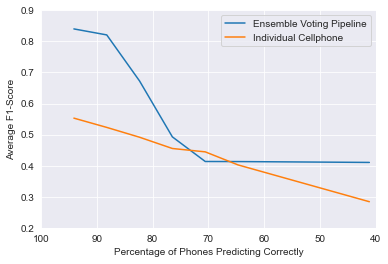

In [13]:
num_flipped=[100,94.12,88.23,82.35,76.47,70.58,64.70,41.17]
# evp_f1=[84.66,83.42,82.75,64.90,50.29,42.04,41.26,41.08]
# indiv_f1=[58.17,55.04,52.15,48.62,45.71,42.12,39.17,28.11]
plot1=plt.plot()
plt.plot(num_flipped,np.array(total_evp_f1),label="Ensemble Voting Pipeline")
plt.plot(num_flipped,np.array(total_indiv_f1),label="Individual Cellphone")
plt.xlabel("Percentage of Phones Predicting Correctly")
plt.ylabel("Average F1-Score")
plt.xlim(100,40)
plt.ylim(0.2,0.9)
#plot.invert_xaxis()
plt.legend()
#plt.savefig("./Plots/resiliency_flipped_plot.pdf",bbox_inches="tight")

# Resiliency Experiments (Dropout) <a class="anchor" id="dropout"></a>

In [28]:
res_indiv_recall=[]
res_indiv_prec=[]
res_indiv_f1=[]
res_indiv_acc=[]
res_evp_recall=[]
res_evp_prec=[]
res_evp_f1=[]
res_evp_acc=[]
dropout_evp_f1=[]
dropout_indiv_f1=[]
import random
def truthLabeler(phoneRanges): #phoneList is a list of all N phone ranges
    """ Labels detection (1 or 0) of the closest phone
    :param phoneRanges: phoneList is a list of all N phones' ranges
    :return: truth_val (1 or 0)
    """
    closest_range=10000
    for x in phoneRanges:
        phone_dist=x[0]
        if phone_dist<closest_range:
            closest_range=phone_dist
    if closest_range <=80:
        truth_val=1 #sUAS
    else:
        truth_val=0 #Noise
    return truth_val

drop_phone_case=[0,1,2,3,4,5,6,10]
for z in drop_phone_case:
    drop_val=z
    res_evp_f1=[]
    res_indiv_f1=[]
    for x in range(18):
        #read scenario and truth data
        truthScenario = truthData.iloc[x]
        pass_num=truthScenario[0]
        scenario=truthScenario[1]
        run_num=truthScenario[2]
        start=truthScenario[3]
        stop=truthScenario[4]
        drone_gps_file=truthScenario[5]
        start_time=datetime.datetime(2021, 8, int(start[6:8]), int(start[9:11]), int(start[11:13]),int(start[13:15])).timestamp()
        stop_time=datetime.datetime(2021, 8, int(stop[6:8]), int(stop[9:11]), int(stop[11:13]),int(stop[13:15])).timestamp()
        testTime= int(stop_time-start_time)
        full_name=(str(scenario) + 'R' + str(run_num) + 'P' + str(pass_num)).strip()
        print(full_name)
        if full_name not in tuning_runs and full_name not in bad_runs:
            indiv_f1=[]
            evp_f1=[]
            dataset_path: str = "C:\\Users\\rclendening\\researchData\\EscapeCell_DataWav_V2\\A3\\"+full_name
            Testdata_dir = pathlib.Path(dataset_path)
            phones = tf.io.gfile.glob(str(Testdata_dir) + '/*')
            featuresLL =create_test_dataset(phones, testTime, testName=full_name)
            # convert to MFCC space
            truth_valueList=[]
            for i in range(len(featuresLL[0][2])):
                phone_ranges=[]
                for j in range(len(featuresLL)): # j is phone
                    if len(featuresLL[j][2]>0):
                        phone_ranges.append([featuresLL[j][2][i]])
                truth_value=truthLabeler(phone_ranges)
                truth_valueList.append(truth_value)
            for r in range(4):
                featuresLL =create_test_dataset(phones, testTime, testName=full_name)
                for y in range(0,drop_val):
                    val=random.randint(0,len(featuresLL)-2)
                    del featuresLL[val]
                predictedList, y_prediction,_= majorityVoteTuning(featuresLL,fusionThresh=0.2,networkThresh=0.9,FSMVal=2)
                num_frames=len(predictedList) #length of one scenario in frames
                tot_indiv_score=0
                tot_recall_score=0
                tot_precision_score=0
                for z in range(len(featuresLL)):
                    if len(featuresLL[z][2]>0):
                        val=featuresLL[z][2]<80
                        indiv_f1.append(f1_score(y_true=val,y_pred=y_prediction[z][0:len(val)]))
                #################### Score Reporting #################
                print(full_name)
                print("Number of used phones:",len(y_prediction))
                fusion_f1_score=f1_score(y_true=truth_valueList,y_pred=predictedList)
                evp_f1.append(fusion_f1_score)
            res_indiv_f1.append(np.average(indiv_f1))
            res_evp_f1.append(np.average(evp_f1))
    dropout_evp_f1.append(np.average(res_evp_f1))
    dropout_indiv_f1.append(np.average(res_indiv_f1))

A3R3P1
A3R3P2
A3R3P2
Number of used phones: 15
A3R3P2
Number of used phones: 15
A3R3P2
Number of used phones: 15
A3R3P2
Number of used phones: 15
A3R3P3
A3R3P3
Number of used phones: 16
A3R3P3
Number of used phones: 16
A3R3P3
Number of used phones: 16
A3R3P3
Number of used phones: 16
A3R3P4
A3R3P5
A3R4P1
A3R4P1
Number of used phones: 19
A3R4P1
Number of used phones: 19
A3R4P1
Number of used phones: 19
A3R4P1
Number of used phones: 19
A3R4P2
A3R4P3
A3R4P3
Number of used phones: 17
A3R4P3
Number of used phones: 17
A3R4P3
Number of used phones: 17
A3R4P3
Number of used phones: 17
A3R4P4
A3R4P5
A3R5P1
A3R5P1
Number of used phones: 15
A3R5P1
Number of used phones: 15
A3R5P1
Number of used phones: 15
A3R5P1
Number of used phones: 15
A3R5P2
A3R5P2
Number of used phones: 14
A3R5P2
Number of used phones: 14
A3R5P2
Number of used phones: 14
A3R5P2
Number of used phones: 14
A3R5P3
A3R5P4
A3R5P4
Number of used phones: 14
A3R5P4
Number of used phones: 14
A3R5P4
Number of used phones: 14
A3R5P4
Numb

In [29]:
dropout_evp_f1.insert(0,0.778)
dropout_indiv_f1.insert(0,0.582)

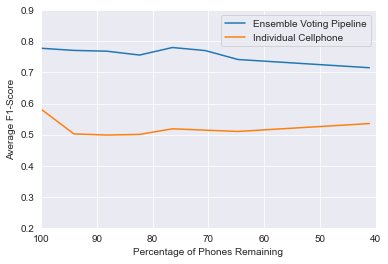

In [30]:
num_flipped=[100,94.12,88.23,82.35,76.47,70.58,64.70,41.17]
plt.xlabel("Percentage of Phones Remaining")
plt.ylabel("Average F1-Score")
plt.xlim(100,40)
plt.ylim(0.2,0.9)
plt.plot(num_flipped,dropout_evp_f1,label="Ensemble Voting Pipeline")
plt.plot(num_flipped,dropout_indiv_f1,label="Individual Cellphone")
plt.legend()
#plt.savefig("./Plots/resiliency_dropout_plot.pdf",bbox_inches="tight")

# Just majority voting (w/o weighting) <a class="anchor" id="no_weight"></a>

In [11]:
import time
indiv_phone_f1_dict={}
indiv_phone_recall_dict={}
indiv_phone_prec_dict={}
for x in phone_slots:
    indiv_phone_f1_dict[x]=[]
    indiv_phone_prec_dict[x]=[]
    indiv_phone_recall_dict[x]=[]

start=0
novelAve=[]
sumAve=[]
outPerform=[]
recall=[]
precision=[]
recall_stddev=[]
score_stddev=[]
phone_count=[]
indiv_precisions=[]
indiv_recalls=[]
indiv_accuracies=[]
indiv_scores=[]
total_pred=[]
total_truth=[]
total_ranges=[]
time_per_prediction=[]
evp_f1=[]
detectable_count=[]
tot_test_time=0
test_truth_evp=[]
test_truth_indiv=[]
#re-defined but same function as before
def majorityVoteAlone(testFeats,networkThresh, FSMVal):
    """Majority voting scheme without weighting
    :param Testfeats: List of all usable devices' MFCC values
     :param networkThresh: Value for NN confidence threshold
     :param FSMVal: FSM selection
     :returns predictedList: List of EVP predictions for the test flight
     :returns y_prediction: 2D list of all cellphones' predictions
     :returns truth_valueList: EVP truth value"""
    y_prediction=[]
    maxVals=[]
    for x in testFeats:
        features_list=x[1]
        features_list -= mean
        features_list /= std
        if len(x[2]) > 0:
            #features_list= np.reshape(features_list, (len(features_list), 40, 1))
            maxVals.append(maxValues(features_list))
            start_time=time.perf_counter()
            pred=loaded_network.predict(features_list)[:] > networkThresh
            #pred=loaded_model.predict(features_list)[:]
            end_time=time.perf_counter()
            time_per_prediction.append((end_time-start_time)/len(pred))
            pred.astype(int)
            #pred = model.predict(x.squeeze()) #for SVM
            y_prediction.append(pred)

    maxVals=np.asarray(maxVals).transpose()
    vote_weights=weighting(maxVals)
    numPhones=len(y_prediction)
    predictedList=[]
    truth_valueList=[]
    prevState=FSMVal**2/2
    for i in range(len(testFeats[0][2])): # i is feature frame
        predictedDrone=0
        phone_ranges=[]
        for j in range(len(y_prediction)): # j is phone
            if y_prediction[j][i] == 1:
                #predictedDrone+= 1*maxValueRankArr[i][j]
                predictedDrone+= 1
            if len(testFeats[j][2]>0):
                phone_ranges.append([testFeats[j][2][i],y_prediction[j][i]]) #this is the range at the current frame
            else:
                phone_ranges.append([100000,y_prediction[j][i]])
        if predictedDrone >0.2*numPhones:
            predictedVal=1
        else:
            predictedVal=0
        if FSMVal ==0:
            prevState, prediction=zeroBitPrediction(prevState, predictedVal)
        if FSMVal ==1:
            prevState, prediction=twoBitPrediction(prevState, predictedVal)
        if FSMVal ==2:
            prevState, prediction=threeBitPrediction(prevState, predictedVal)
        if FSMVal ==3:
            prevState, prediction=fourBitPrediction(prevState, predictedVal)
        predictedList.append(prediction)
        best_indiv_predict,truth_value=findClosestPhone(phone_ranges)
        truth_valueList.append(truth_value)

    return predictedList, y_prediction,truth_valueList

for x in range(18):
    #read scenario and truth data
    truthScenario = truthData.iloc[x]
    pass_num=truthScenario[0]
    scenario=truthScenario[1]
    run_num=truthScenario[2]
    start=truthScenario[3]
    stop=truthScenario[4]
    drone_gps_file=truthScenario[5]
    start_time=datetime.datetime(2021, 8, int(start[6:8]), int(start[9:11]), int(start[11:13]),int(start[13:15])).timestamp()
    stop_time=datetime.datetime(2021, 8, int(stop[6:8]), int(stop[9:11]), int(stop[11:13]),int(stop[13:15])).timestamp()
    testTime= int(stop_time-start_time)
    full_name=(str(scenario) + 'R' + str(run_num) + 'P' + str(pass_num)).strip()
    print(full_name)
    if full_name not in tuning_runs and full_name not in bad_runs:
        dataset_path: str = "C:\\Users\\rclendening\\researchData\\EscapeCell_DataWav_V2\\A3\\"+full_name
        Testdata_dir = pathlib.Path(dataset_path)
        phones = tf.io.gfile.glob(str(Testdata_dir) + '/*')
        tot_test_time+=testTime
        # convert to MFCC space
        featuresLL =create_test_dataset(phones, testTime, testName=full_name)
        predictedList, y_prediction,truth_valueList= majorityVoteAlone(featuresLL,fusionThresh=0.2,networkThresh=0.90,FSMVal=2)
        # if full_name== "A3R6P2":
        #     names=pd.DataFrame()
        #     i=0
        #     for x in featuresLL:
        #         names[x[0]]=y_prediction[i].squeeze()
        #         i+=1
        #     # R6P2_truth=pd.DataFrame(predictedList)
        #     # R6P2_truth.to_csv("R6P2_truth.csv")
        #     names.to_csv("R6P2_truth_v2.csv")
        num_frames=len(predictedList) #length of one scenario in frames
        # Report balanced accuracy scores
        tot_indiv_score=0
        tot_recall_score=0
        tot_precision_score=0
        tot_detectable=np.zeros(num_frames)
        for z in range(len(y_prediction)): #iterate over cellphones
            if len(featuresLL[z][2]>0):
                for range_val in range(len(featuresLL[z][2])):
                    if featuresLL[z][2][int(range_val)]<80:
                        total_ranges.append(featuresLL[z][2][int(range_val)])
                val=featuresLL[z][2]<80
                tot_detectable+=val
                phone_name= featuresLL[z][0]
                if phone_name== "Phone_3-2":
                    print("USED HERE")
                    print(f1_score(y_true=val,y_pred=y_prediction[z][0:len(val)]))
                    print("--------------")
                total_truth.extend(val)
                total_pred.extend(y_prediction[z][0:len(val)])
                indiv_phone_f1_dict[phone_name].append(f1_score(y_true=val,y_pred=y_prediction[z][0:len(val)]))
                indiv_phone_recall_dict[phone_name].append(recall_score(y_true=val,y_pred=y_prediction[z][0:len(val)]))
                indiv_phone_prec_dict[phone_name].append(precision_score(y_true=val,y_pred=y_prediction[z][0:len(val)]))
                indiv_accuracies.append(accuracy_score(y_true=val,y_pred=y_prediction[z][0:len(val)]))
                indiv_recalls.append(recall_score(val,y_prediction[z][0:len(val)]))
                indiv_precisions.append(precision_score(val,y_prediction[z][0:len(val)]))
                indiv_scores.append(f1_score(y_true=val,y_pred=y_prediction[z][0:len(val)]))
        test_truth_evp.extend(truth_valueList)
        test_truth_indiv.extend(featuresLL[0][2]<80)
        #################### Score Reporting #################
        detectable_count.extend(tot_detectable[np.where(tot_detectable!=0)])
        indiv_score_ave=np.average(indiv_scores)
        print(full_name)
        print("Number of used phones:",len(y_prediction))
        fusion_score=accuracy_score(y_true=truth_valueList,y_pred=predictedList)
        fusion_f1_score=f1_score(y_true=truth_valueList,y_pred=predictedList)
        novelAve.append(fusion_score)
        phone_count.append([len(y_prediction),fusion_f1_score])
        print("Average Recall value:", recall_score(truth_valueList,predictedList))
        print("Average Precision value:", precision_score(truth_valueList,predictedList))
        print("Accuracy for drone present:", fusion_score)
        print("Indiv Accuracy for drone present:", indiv_score_ave)
        performanceGain=100*((fusion_f1_score-indiv_score_ave)/indiv_score_ave)
        evp_f1.append(fusion_f1_score)
        outPerform.append(performanceGain)
        recall.append(recall_score(truth_valueList,predictedList))
        precision.append(precision_score(truth_valueList,predictedList))
        # print("Recall score:", recall_score(truth_valueList,predictedList))
        # print("Precision score:", precision_score(truth_valueList,predictedList))
        # print("Novel method outperforms by:", performanceGain, "%")
        print("_________________________")
        if full_name == "A3R4P1":
            print()
        # for x in range(len(featuresLL)):
        #     if len(featuresLL[x][2]>0):
        #         plt.title(featuresLL[x][0])
        #         plt.plot(featuresLL[x][2],y_prediction[x][0:len(featuresLL[x][2])])
        #         #plt.plot(range(0,len(y_prediction[0])),y_prediction[x])
        #         plt.figure()
        # plt.plot(range(0,len(truth_valueList)),truth_valueList)
        # plt.plot(range(0,len(predictedList)),predictedList)

print("Indiv Recall", np.average(indiv_recalls))
print("Indiv Precision", np.average(indiv_precisions))
print("Indiv F1", np.average(indiv_scores))
print("EVP Recall",np.average(recall))
print(" EVP Precision",np.average(precision))
print("EVP Accuracy",np.average(novelAve))
print("EVP F1",np.average(evp_f1))
print("Indiv Accuracy", np.average(indiv_accuracies))
print("Outperform",np.average(outPerform))

A3R3P1
A3R3P2
12/12 [==============================] - 0s 2ms/step
A3R3P2
Number of used phones: 16
Average Recall value: 0.4020618556701031
Average Precision value: 1.0
Accuracy for drone present: 0.8469656992084432
Indiv Accuracy for drone present: 0.659699708257214
_________________________
A3R3P3
12/12 [==============================] - 0s 2ms/step
A3R3P3
Number of used phones: 17
Average Recall value: 0.4387755102040816
Average Precision value: 0.9772727272727273
Accuracy for drone present: 0.851063829787234
Indiv Accuracy for drone present: 0.6698599715653795
_________________________
A3R3P4
A3R3P5
A3R4P1
12/12 [==============================] - 0s 3ms/step
A3R4P1
Number of used phones: 20
Average Recall value: 0.6288659793814433
Average Precision value: 0.9104477611940298
Accuracy for drone present: 0.8888888888888888
Indiv Accuracy for drone present: 0.615720072390955
_________________________

A3R4P2
A3R4P3
12/12 [==============================] - 0s 4ms/step
A3R4P3
Number of 